# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn import set_config
set_config(display='diagram')

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.logloss = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1.0 / (1.0 + np.exp(-np.dot(X, weights.T))) 
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        return np.sum(np.log(1+np.e**(-np.dot(x, weights.T)*y)))/x.shape[0]+np.linalg.norm(weights)*0.5*self.C
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            pred_y = 1 - 1 / (1 + np.exp(-(np.dot(X_ext, self.weights_.T)*y)))
            delta = self.weights_/self.C - np.dot(y*X_ext.T, pred_y)/X_ext.shape[0]
            self.logloss.append(self.get_loss(X_ext, self.weights_, y))
            self.weights_ -= self.eta * delta
            
            if np.linalg.norm(self.eta * delta) < self.tol:                  
                break
                
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return np.where(self.predict_proba(X) > 0.5, 1, -1)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")

In [6]:
from sklearn import datasets
from sklearn import metrics

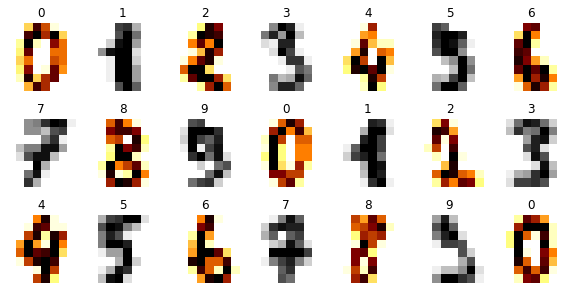

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

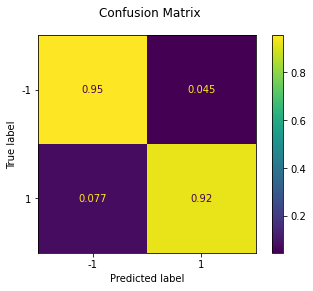

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

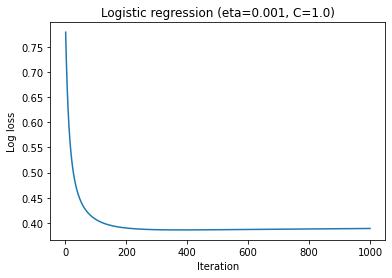

In [18]:
sns.lineplot(x=range(1, len(model.logloss)+1), y=model.logloss)
plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.title(f'Logistic regression (eta=0.001, C=1.0)');

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

In [19]:
eta_val = [0.0001, 0.001, 0.005, 0.01, 0.1, 0.5]
train_metric, test_metric, logloss = [], [], {}
for eta in eta_val:
    clf = CustomLogisticRegression(eta=eta)
    clf.fit(X_train, y_train)
    logloss[eta] = clf.logloss
    train_metric.append( metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
    test_metric.append(metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

<ipython-input-5-dcf20b0110a4>:58: RuntimeWarning: overflow encountered in exp
  pred_y = 1 - 1 / (1 + np.exp(-(np.dot(X_ext, self.weights_.T)*y)))
<ipython-input-5-dcf20b0110a4>:38: RuntimeWarning: overflow encountered in power
  return np.sum(np.log(1+np.e**(-np.dot(x, weights.T)*y)))/x.shape[0]+np.linalg.norm(weights)*0.5*self.C


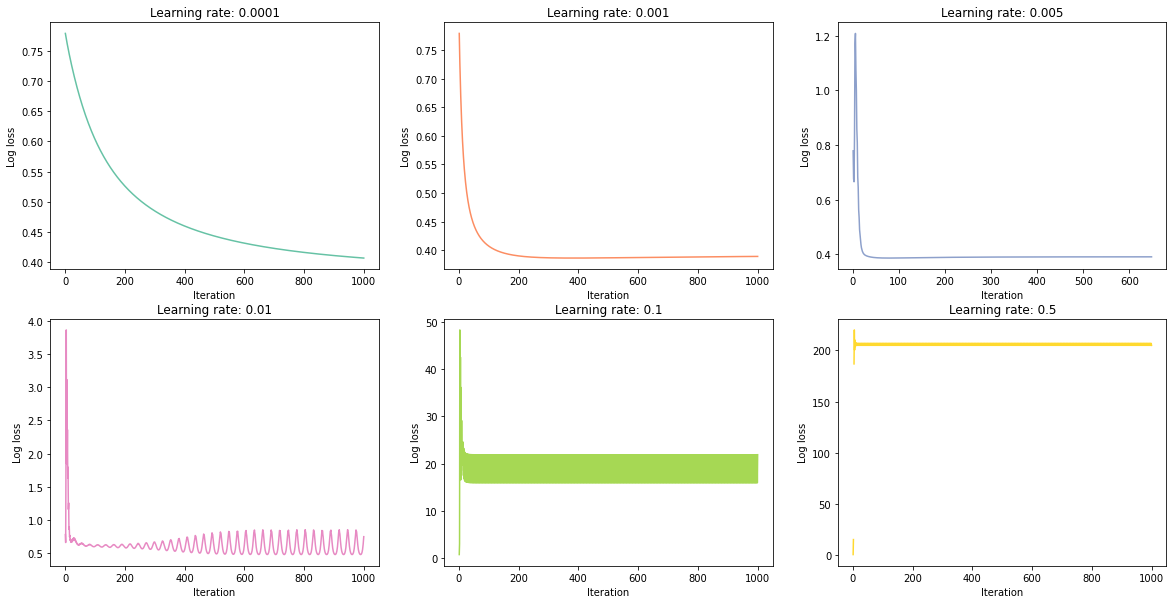

In [20]:
plt.figure(figsize=(20, 10))
palette = itertools.cycle(sns.color_palette("Set2"))
for i, key in enumerate(logloss.keys(), 1):
    c = next(palette)
    plt.subplot(2,3,i)
    sns.lineplot(x=range(1, len(logloss[key])+1), y=logloss[key], color=c) 
    plt.xlabel('Iteration')
    plt.ylabel('Log loss')
    plt.title(f'Learning rate: {key}')

In [21]:
pd.DataFrame({'eta':eta_val, 'train_metric':train_metric, 'test_metric':test_metric}).\
        sort_values(['test_metric', 'train_metric'], ascending=False)

,eta,train_metric,test_metric
2,0.0050,0.915797,0.944444
1,0.0010,0.910926,0.938889
0,0.0001,0.884482,0.911111
3,0.0100,0.773138,0.752778
4,0.1000,0.545581,0.527778
5,0.5000,0.496868,0.491667


Summary

В случае, когда learning rate слишком маленький, при заданном количестве циклов модель не успевает сойтись, так как шаги градиентного спуска слишком маленькие, с другой стороны, с ростом learning rate модель также не может сойтись, так как алгоритм "проскакивает" минимум. На примере рассмотренных значений learning rate видно, что при самых низких значениях (0.0001, 0.0010) модель сходится медленно. При увеличении learning rate до 0.1 видно, что алгоритм колеблется около минимального значения, однако не может достич его. При еще большем увеличении learning rate алгоритм и вовсе "выбрасывает" на большие значения, то есть достигнуть минимума он не может, а значит и модель не сходится.
Эффективно применение изменяющегося learning rate. В начале задаются большие значения, а с ростом итераций - меньшие, таким образом, с одной стороны алгоритм быстрее двигается к минимуму в начале, а с другой - при приближении к минимуму не проскакивает его, так как размер шагов (learning rate) уже небольшой.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [22]:
C_values = [1.0, 1.5, 2.0, 3.0, 5.0]
train_metric, test_metric, logloss = [], [], {}
for c in C_values:
    clf = CustomLogisticRegression(C=c)
    clf.fit(X_train, y_train)

    logloss[c] = clf.logloss
    train_metric.append( metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train))
    test_metric.append(metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

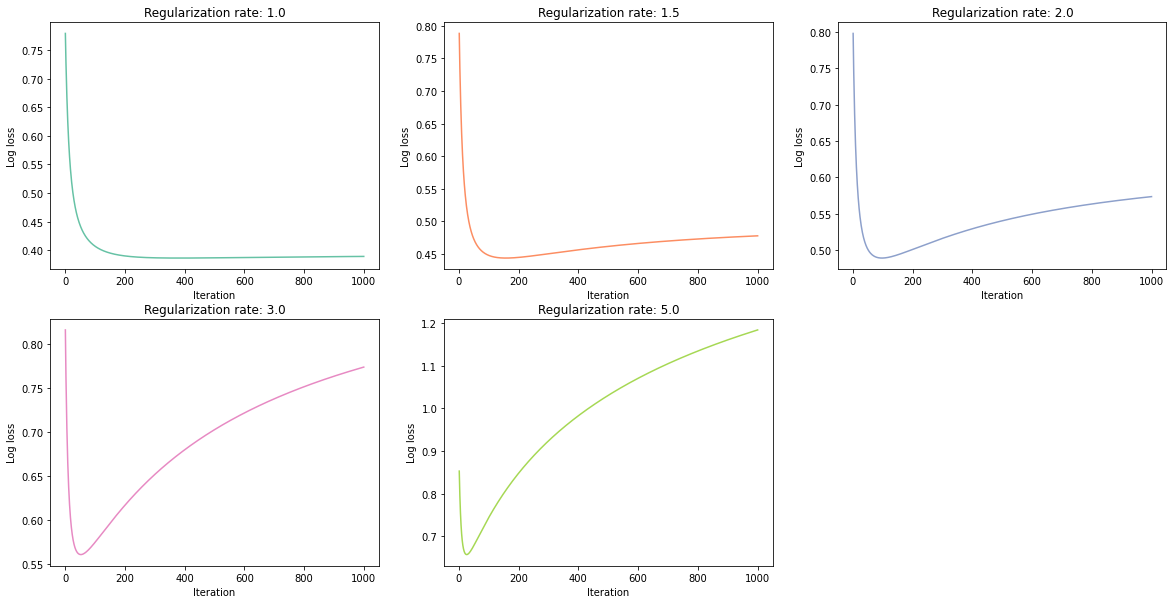

In [23]:
plt.figure(figsize=(20, 10))
palette = itertools.cycle(sns.color_palette("Set2"))

for i, key in enumerate(logloss.keys(), 1):
    c = next(palette)
    plt.subplot(2,3,i)
    sns.lineplot(x=range(1, len(logloss[key])+1), y=logloss[key], color=c)
    plt.xlabel('Iteration')
    plt.ylabel('Log loss')
    plt.title(f'Regularization rate: {key}')


In [24]:
pd.DataFrame({'C':C_values, 'train_metric':train_metric, 'test_metric':test_metric}).\
        sort_values(['test_metric', 'train_metric'], ascending=False)

,C,train_metric,test_metric
3,3.0,0.915101,0.944444
4,5.0,0.915101,0.944444
2,2.0,0.913709,0.944444
1,1.5,0.913013,0.941667
0,1.0,0.910926,0.938889


С ростом регуляризационного параметра, веса становятся все меньше и модель не может сойтись. В результате растет и ошибка

**(0.5 points)** Compare zero initialization and random initialization. 

In [25]:

zero_model = CustomLogisticRegression(zero_init=True, eta=0.005, max_iter=1000)
random_model = CustomLogisticRegression(zero_init=False, eta=0.005, max_iter=1000)
zero_model.fit(X_train, y_train)
random_model.fit(X_train, y_train)
test_acc_zero = metrics.accuracy_score(y_pred=zero_model.predict(X_test), y_true=y_test)
test_acc_random = metrics.accuracy_score(y_pred=random_model.predict(X_test), y_true=y_test)


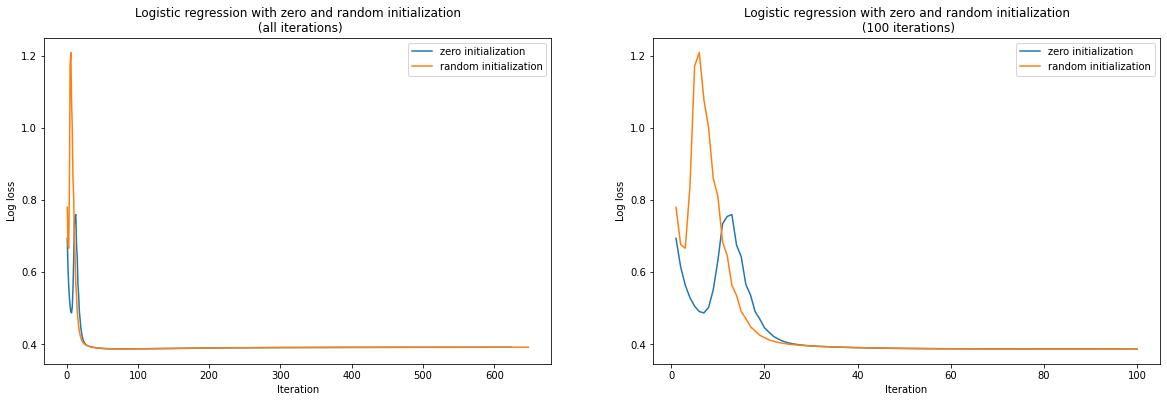

In [26]:
f,ax=plt.subplots(1,2,figsize=(20, 6))
sns.lineplot(x=range(1, len(zero_model.logloss)+1), y=zero_model.logloss, label='zero initialization', ax=ax[0]);
sns.lineplot(x=range(1, len(random_model.logloss)+1), y=random_model.logloss, label='random initialization', ax=ax[0])
ax[0].set_title(f'Logistic regression with zero and random initialization\n (all iterations)');
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Log loss')
sns.lineplot(x=range(1, 101), y=zero_model.logloss[:100], label='zero initialization', ax=ax[1]);
sns.lineplot(x=range(1, 101), y=random_model.logloss[:100], label='random initialization', ax=ax[1])
ax[1].set_title(f'Logistic regression with zero and random initialization\n (100 iterations)');
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Log loss')

plt.legend();


При случайной инициализации коэффициентов модель выдает больший уровень ошибки в начале обучения, однако затем ошибка быстро падает. При инициализации нулями колебания ошибки не так значительны.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [27]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.linalg.norm(X[:, None, :] - Y[None, :, :], axis=-1)       
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.array([np.sum(weights[y == class_k]) for class_k in self.classes_])
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            weights_of_points = np.ones(P.shape)
            indices = np.argpartition(P, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            if self.weights == 'distance':
                weights_of_points = 1/(P+self.eps)
                
                indices = np.argpartition(weights_of_points, -self.n_neighbors, axis=1)[:, -self.n_neighbors:]
            weights_of_nearest = np.take_along_axis(weights_of_points, indices, axis=1) 
            y_neig = self.y[indices] 
            y = np.empty([weights_of_nearest.shape[0], len(self.classes_)])
            for vec in range(weights_of_nearest.shape[0]):
                y[vec, :] = self.get_class_weights(y_neig[vec, :], weights_of_nearest[vec, :])
                y[vec, :] = y[vec, :]/np.sum(y[vec, :])
            return y       
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        inx = np.argmax(self.predict_proba(X), axis=1)
        y = self.classes_[inx]
        return y

In [28]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [29]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [30]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

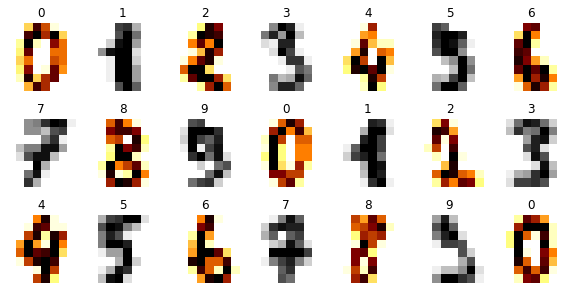

In [31]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [32]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [33]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

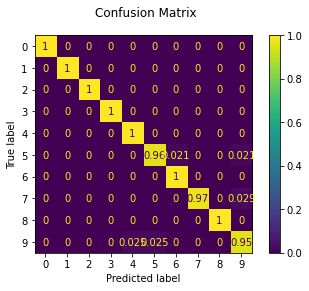

In [34]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [35]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

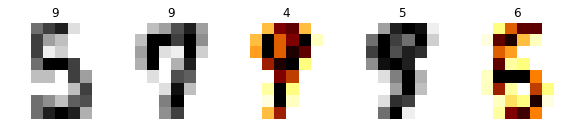

In [36]:
pred = model.predict(X_test)
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes.flatten(), X_test[np.where(y_test!=pred)], pred[np.where(y_test!=pred)]):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

Модель в целом показывает очень хорошие метрики. Некоторая неточность показана для классов 5, 7 и 9. Класс 5 в 2.1% случаев определяется как 6, и в 2.1% случаев - как 9. Класс 7 в 2.9% случаев определяется как 9, а класс 9 - как 4 и 5 в 2.5% случаев. В целом, это предсказуемо, так как написание цифр похоже.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [37]:
error = []

for i in range(1, 40):
    knn = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

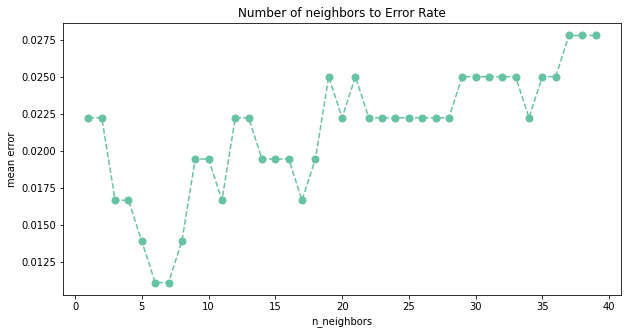

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 40), error, color=sns.color_palette("Set2")[0], linestyle='dashed', marker='o', markersize=7, )
plt.title('Number of neighbors to Error Rate')
plt.xlabel('n_neighbors')
plt.ylabel('mean error');

Поиск оптимального значения параметра n_neighbors - это оптимизационная задача. В случае, если значение слишком маленькое (например, 1), модель переобучается, при увеличение количества учитываемых соседей, ошибка снижается и достигает минимума (в нашем случае при значении 5 и 6), а затем начинает расти опять, так как начинают учитываться слишком далекие наблюдения.


**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

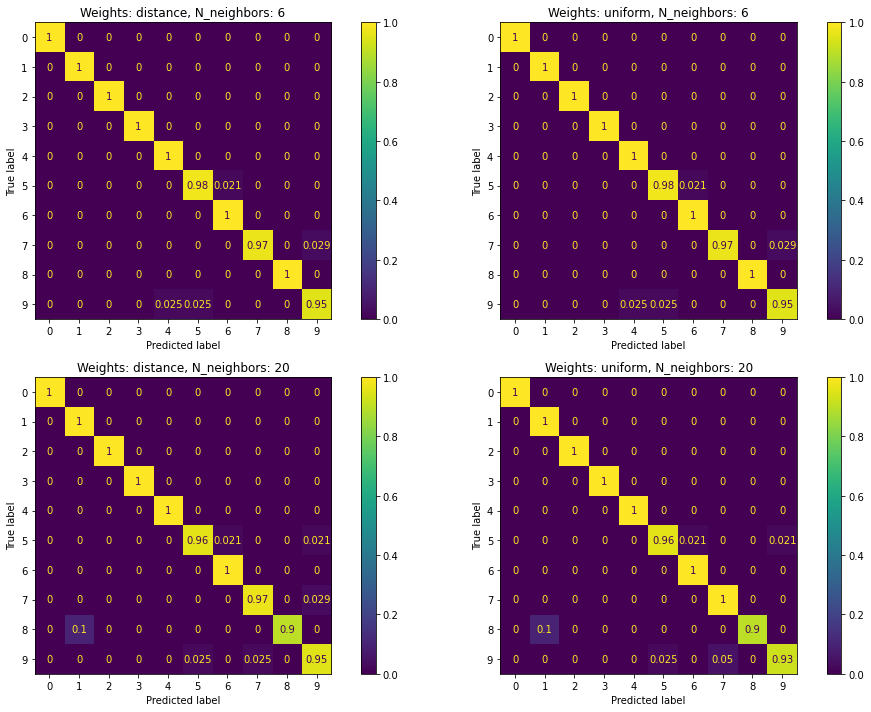

In [39]:
test_metric = []
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
w_type = ['distance', 'uniform', 'distance', 'uniform']
neib_all = [6, 6, 20, 20]

for w, n, ax in zip(w_type, neib_all, axes.flatten()):
        knn = CustomKNeighborsClassifier(n_neighbors=n, weights=w)
        knn.fit(X_train, y_train)
        test_metric.append(metrics.accuracy_score(y_pred=knn.predict(X_test), y_true=y_test))
        plot_confusion_matrix(knn, X_test,y_test, normalize='true',
                              ax=ax)
        ax.title.set_text(f'Weights: {w}, N_neighbors: {n}')
        plt.tight_layout()  


In [40]:

pd.DataFrame({'weights': w_type, 'n_neighbors': neib_all, 'test_metric':test_metric}).\
        sort_values(['test_metric'], ascending=False)

,weights,n_neighbors,test_metric
0,distance,6,0.988889
1,uniform,6,0.988889
2,distance,20,0.977778
3,uniform,20,0.977778


При "uniform" параметре все учитываемые ближайшие наблюдения ("соседи") рассматриваются с одинаковыми весами, при "distance" параметре большие веса даются более близким наблюдениями среди "соседей". В зависимости от структуры данных оба метода могут показать лучшие результаты. Параметр, как правило, подбирается экспериментально. В нашем случае различия не велики, хотя при большом количестве учитываемых "соседей" отдельные классы начинают предсказываться по-разному.


**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

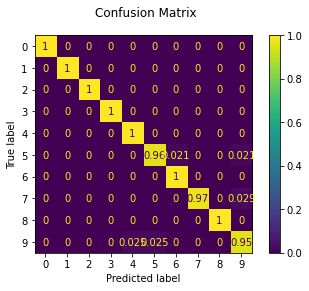

In [41]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [42]:
test_metric = []
dist = ['euclidean', 'minkowski', 'chebyshev', 'manhattan']

for m, ax in zip(dist, axes.flatten()):
    if m=='minkowski':
        knn = KNeighborsClassifier(n_neighbors=5, metric=m, p=4)
    else:
        knn = KNeighborsClassifier(n_neighbors=5, metric=m)
    knn.fit(X_train, y_train)
    test_metric.append(metrics.accuracy_score(y_pred=knn.predict(X_test), y_true=y_test))
pd.DataFrame({'metric': dist, 'test_metric':test_metric}).\
        sort_values(['test_metric'], ascending=False)

,metric,test_metric
1,minkowski,0.988889
0,euclidean,0.986111
2,chebyshev,0.980556
3,manhattan,0.980556


KNN использует различные функции измерения расстояния между объектами. Кроме Euclidean Distance популярными также являются 
Manhattan Distance $sum(|x - y|)$, Cheybchev Distance $max(|x - y|)$, Minkowski Distance $sum(w * |x - y|^p)^{(1/p)}$.
В нашем случае лучшие результаты получены при использовании Minkowski Distance (при n_neighbors=5).


**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Дистанционные функции подбираются в завасимости от задачи. Например, вышеописанные подходят для рассчета расстояний между числовыми векторами. 
Другим примером задач является рассчет растояния между текстами или булевыеми векторами. Для них подойдет Hamming distance.
 

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [43]:
PATH = "./data/"

In [44]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [45]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

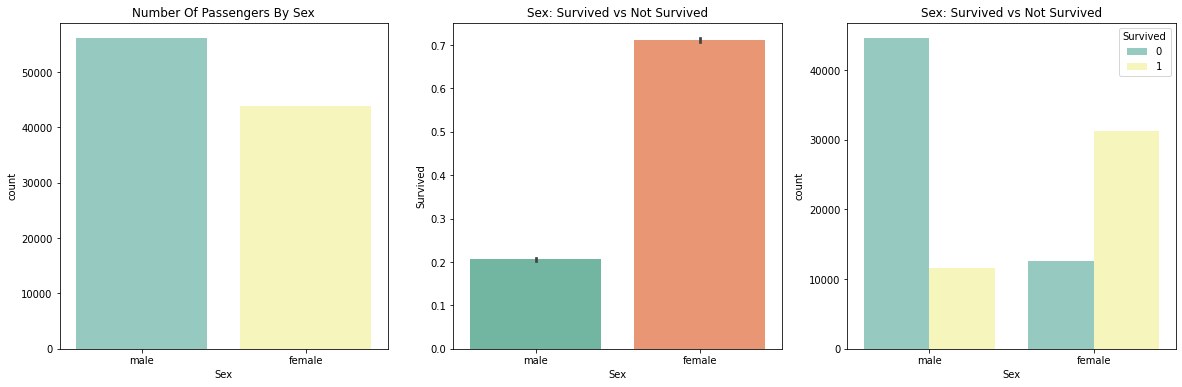

In [46]:
f,ax=plt.subplots(1,3,figsize=(20, 6))
sns.countplot(x="Sex", data=data ,ax=ax[0], palette="Set3")
ax[0].set_title('Number Of Passengers By Sex')
sns.barplot(x='Sex',y='Survived', data=data, ax=ax[1], palette="Set2" )
ax[1].set_title('Sex: Survived vs Not Survived');
sns.countplot(x='Sex',hue='Survived',data=data, ax=ax[2],  palette="Set3" )
ax[2].set_title('Sex: Survived vs Not Survived');

Несмотря на то, что количество пассажиров мужского пола превышает количество пассажиров женского пола (56.11% и 43.89%, соответственно), процент выживших женщин составляет 71.15%, в то время как среди мужчин выжили только 20.58%.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

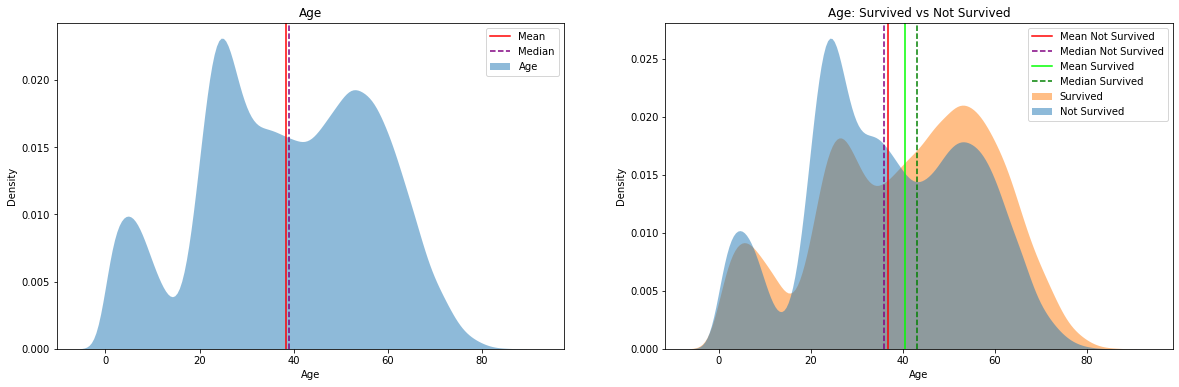

In [47]:
f,ax=plt.subplots(1,2,figsize=(20, 6))
sns.kdeplot(data=data, x="Age",
   fill=True, common_norm=False, 
   alpha=.5, linewidth=0, ax=ax[0], palette="Set1")
ax[0].axvline(x=data['Age'].mean(),  color = 'red', label = 'Mean')
ax[0].axvline(x=data['Age'].median(), linestyle = '--', color = 'purple', label = 'Median')
ax[0].legend(['Mean','Median','Age'])
ax[0].set_title('Age')

sns.kdeplot(data=data, x="Age", hue="Survived",
   fill=True, common_norm=False, ax=ax[1], alpha=.5, linewidth=0) 
ax[1].set_title('Age: Men vs Women')

ax[1].axvline(x=data.loc[data.Survived==0, 'Age'].mean(),   color = 'red', label = 'Mean Not Survived')
ax[1].axvline(x=data.loc[data.Survived==0, 'Age'].median(), linestyle = '--', color = 'purple', label = 'Median Not Survived')
ax[1].axvline(x=data.loc[data.Survived==1, 'Age'].mean(),   color = 'lime', label = 'Mean Survived')
ax[1].axvline(x=data.loc[data.Survived==1, 'Age'].median(), linestyle = '--', color = 'green', label = 'Median Survived')
ax[1].legend(['Mean Not Survived','Median Not Survived','Mean Survived', 'Median Survived', 'Survived', 'Not Survived'])
ax[1].set_title('Age: Survived vs Not Survived')

plt.show()

In [48]:
median_serv = pd.DataFrame(data.groupby('Survived')['Age'].median()).rename(columns={'Age':'median'})
age_serv = data.groupby('Survived')['Age'].describe().merge(median_serv, left_index=True, right_index=True)
median = pd.DataFrame({'median':data['Age'].median()}, index=['Age'])
age = pd.DataFrame(data['Age'].describe()).T.merge(median, left_index=True, right_index=True)
pd.concat([age, age_serv])

,count,mean,std,min,25%,50%,75%,max,median
Age,96708.0,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0,39.0
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0,36.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0,43.0


При анализе связи возраста и вероятности выживания видно, что наименьшая вероятность выжить была в диапазоне 25-36 лет (средняя и медиана около 36). Среди выживших средний возраст составил 40.6 лет с медианой - 43.0. То есть в среднем возраст выживших был выше.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

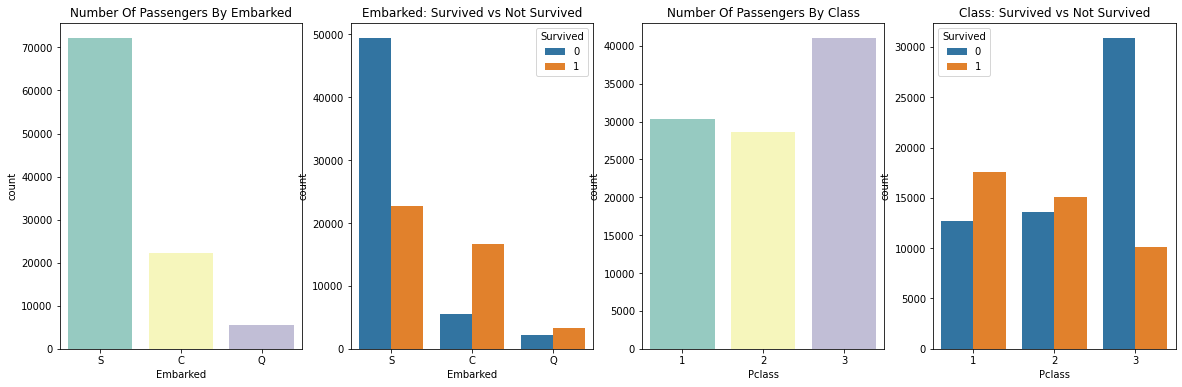

In [49]:
f,ax=plt.subplots(1,4,figsize=(20, 6))
sns.countplot(x="Embarked", data=data ,ax=ax[0], palette="Set3")
ax[0].set_title('Number Of Passengers By Embarked')

sns.countplot(x='Embarked',hue='Survived',data=data, ax=ax[1])
ax[1].set_title('Embarked: Survived vs Not Survived')

sns.countplot(x='Pclass',data=data, ax=ax[2], palette="Set3" )
ax[2].set_title('Number Of Passengers By Class')

sns.countplot(x='Pclass',hue='Survived', data=data, ax=ax[3], )
ax[3].set_title('Class: Survived vs Not Survived')

plt.show()

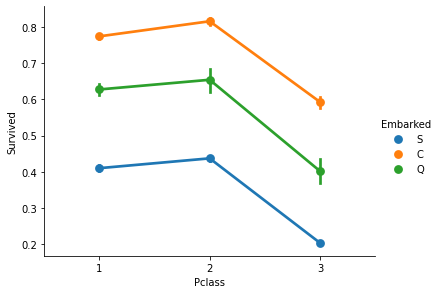

In [50]:
sns.catplot(x="Pclass", y="Survived", hue="Embarked", kind="point", data=data, height=4, aspect=1.3);

In [51]:
data.Pclass.value_counts(normalize=True)


3    0.41006
1    0.30315
2    0.28679
Name: Pclass, dtype: float64

In [52]:
pd.DataFrame(data.groupby('Pclass')['Survived'].value_counts(normalize=True))

Survived
Pclass Survived          
1      1         0.579779
       0         0.420221
2      1         0.525018
       0         0.474982
3      0         0.752695
       1         0.247305

In [53]:
data.Embarked.value_counts(normalize=True)

S    0.723198
C    0.222426
Q    0.054376
Name: Embarked, dtype: float64

In [54]:
pd.DataFrame(data.groupby('Embarked')['Survived'].value_counts(normalize=True))

Survived
Embarked Survived          
C        1         0.751296
         0         0.248704
Q        1         0.596976
         0         0.403024
S        0         0.684706
         1         0.315294

По признаку Class наибольшее число пассажиров принадлежали к третьему классу (41.0%), однако количество выживших среди них составило только 24.73%, в то время как процент выживших 1 и 2 класса составил 57.97% и 52.50%, соответственно.
По признаку Embarked наибольшее число пассажиров направлялось в порт S (72.32%), однако количество выживших среди них составило только 31.53%, в то время как процент выживших среди пассажиров, у которых билеты были до портов С и Q, составили, соответственно, 75.12% и  59.70%.
При анализе взаимосвязи признаков порт S направлялось 35895 пассажиров 3 класса, то есть 35.9% 
Проанализируем влияние комбинации категорий признаков Sex и Pclass на вероятность выживания.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [55]:
(data.isna().sum()/data.shape[0]).sort_values(ascending=False)

Cabin       0.67866
Ticket      0.04623
Age         0.03292
Embarked    0.00250
Fare        0.00134
Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
SibSp       0.00000
Parch       0.00000
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Для признака *Cabin* отсутствуют значения для 67,9% наблюдений, поэтому. \
Также отсутствуют значения для ~3-5% наблюдений по признакам *Age* и *Ticket*.\
Отсутствующие значения можно заполнить средней либо медианой для числовых значений (Age, Fare). Для этого необходимо оценить нормальность распределения данных признаков. Для категориальных признаков можно создать отдельный класс, можно также присвоить значения другого наиболее распространенного класса.
Наиболее радикальный метод - удалить все записи, содержащие пропущенные значения, однако в таком случае можно потерять значительную часть информации, так как датасет небольшого размера.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [56]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


Для начала разделим выборку на трэйн и тест, так как предобработку данных необходимо проводить отдельно.


In [78]:
y = data['Survived'].to_numpy()
X = data[data.columns[1:]]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

У признака Cabin 26992 уникальных значений. Каждое значение начинается с буквы, далее следует набор из цифр. Извлечем первую букву из каждого значения признака и перепишем признак Cabin. В результате данного преобразования количество значений у данного признака сократится до 9. 
Количество уникальных значений признака Ticket составляет 75331, что также делает его непригодным для анализа и построения предсказательных моделей. Номер билет может состоять только из цифр, либо из букв и цифр. Создадим отдельную категорию digit для всех билетов, состоящих только из цифр. Для билетов, номера которых содержат буквы, извлечем буквенные обозначения, а также удалим несмысловые, вероятно, символы (. и /) для уменьшения числа категорий. Сохраним данные в переменную Ticket. В итоге остается 37 категорий.

In [80]:
def cabin_ticket_preproc(data):
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data.loc[data['Cabin']=='n', 'Cabin'] = np.nan

    data['Ticket'] = data['Ticket'].apply(lambda x: str(x).split()[0])
    data.loc[data['Ticket'].apply(lambda x: x.isdigit()), 'Ticket'] = 'digit'
    data['Ticket'] = data['Ticket'].apply(lambda x: x.replace('/', '').replace('.', ''))
    data.loc[data['Ticket']=='nan', 'Ticket'] = np.nan
    return data

In [81]:
X_train = cabin_ticket_preproc(X_train)
X_test = cabin_ticket_preproc(X_test)

C:\Users\314Dell\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\314Dell\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Нормализуем показатель Fare, так как для него характерны выбросы.

In [82]:
mean = X_train['Fare'].mean()
std = X_train['Fare'].std()
X_train['Fare'] = (X_train['Fare'] - mean)/std
X_test['Fare'] = (X_test['Fare'] - mean)/std

Заменим пропущенные значения для категориальных признаков 'Ticket', 'Cabin', 'Embarked' значением no_data.
Заменим попущенные значения для количественной переменной 'Age' средний значением по переменной 'Pclass', 'Fare' - средним значением признака по обучающей выборке.

In [83]:
age_dict = X_train[['Age', 'Pclass']].dropna().groupby('Pclass').mean().round(0).to_dict()
X_train['Age'] = X_train['Age'].fillna(X_train.Pclass.map(age_dict['Age']))
X_test['Age'] = X_test['Age'].fillna(X_test.Pclass.map(age_dict['Age']))

mean=X_train['Fare'].mean()
X_train['Fare'] = X_train['Fare'].fillna(mean)
X_test['Fare'] = X_test['Fare'].fillna(mean)

val='no_data'
for col in ['Ticket', 'Cabin', 'Embarked']:
    X_train[col]  = X_train[col].fillna(val)
    X_test[col] = X_test[col].fillna(val)


Удалим колонку 'Name', так как она содержит количество уникальных значений, равное количество наблюдей, следовательно нерпигодна для моделирования.

In [84]:
X_train = X_train.drop('Name', axis=1)
X_test = X_test.drop('Name', axis=1)

In [85]:
#функция для предобработки новых данных (без целевой переменной)
def new_data(df, X_train):
    
    df = cabin_ticket_preproc(df)  
    std = X_train['Fare'].std()
    
    df['Fare'] = (df['Fare'] - mean)/std

    age_dict = X_train[['Age', 'Pclass']].dropna().groupby('Pclass').mean().round(0).to_dict()
    df['Age'] = df['Age'].fillna(df.Pclass.map(age_dict['Age']))
    mean = X_train['Fare'].mean()


    mean=X_train['Fare'].mean()
    df['Fare'] = df['Fare'].fillna(mean)

    val='no_data'
    for col in ['Ticket', 'Cabin', 'Embarked']:
        df[col]  = df[col].fillna(val)

    df = df.drop('Name', axis=1)
    
    
    return df

Стандартизируем количественные переменные при помощи StandardScaler, а категориальные переведем в векторы при помощи OneHotEncoder.

In [86]:

def make_model(cat_feat, num_feat, model_type='reg', solver='saga',
                    max_iter=1000, C=1.0, tol=1e-5, random_state=42,  penalty='l2',
                n_neighbors=5, weights='uniform'):
    
    # linear regression
    if model_type == 'reg':
        model = LogisticRegression( penalty=penalty, max_iter=max_iter, C=C, tol=tol, random_state=random_state, solver=solver)
    # KNN,
    elif model_type == 'knn':
        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)

 
    preprocessing = ColumnTransformer(
        [('cat', OneHotEncoder(), cat_feat),
        ('num', StandardScaler(), num_feat)])


    return Pipeline([
            ("preprocess", preprocessing),
            ('mod', model)
        ])


In [87]:
num_feat = ['Age', 'Fare']
cat_feat = ['Pclass', 'Sex',  'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

In [88]:
results = cross_validate(make_model(model_type='reg', num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
error_ac = np.mean(results['test_accuracy'])
error_f1 = np.mean(results['test_f1'])
print(f'Logistic regression: accuracy: {error_ac:.2f}, f1: {error_f1:.2f}')

Logistic regression: accuracy: 0.78, f1: 0.73


In [68]:
results = cross_validate(make_model(model_type='reg', num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
error_ac = np.mean(results['test_accuracy'])
error_f1 = np.mean(results['test_f1'])
print(f'Logistic regression: accuracy: {error_ac:.2f}, f1: {error_f1:.2f}')

Logistic regression: accuracy: 0.78, f1: 0.73


In [69]:
results = cross_validate(make_model(model_type='knn', num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
error_ac = np.mean(results['test_accuracy'])
error_f1 = np.mean(results['test_f1'])
print(f'Logistic regression: accuracy: {error_ac:.2f}, f1: {error_f1:.2f}')

Logistic regression: accuracy: 0.75, f1: 0.71


In [70]:
X_train_2 = X_train.drop('Ticket', axis=1)
X_test_2 = X_test.drop('Ticket', axis=1)
cat_feat = ['Pclass', 'Sex',  'Cabin', 'SibSp', 'Parch', 'Embarked']

In [72]:
results = cross_validate(make_model(model_type='reg', num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train_2, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
error_ac = np.mean(results['test_accuracy'])
error_f1 = np.mean(results['test_f1'])
print(f'Logistic regression: accuracy: {error_ac:.2f}, f1: {error_f1:.2f}')

Logistic regression: accuracy: 0.77, f1: 0.72


In [73]:
results = cross_validate(make_model(model_type='knn', num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train_2, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
error_ac = np.mean(results['test_accuracy'])
error_f1 = np.mean(results['test_f1'])
print(f'Logistic regression: accuracy: {error_ac:.2f}, f1: {error_f1:.2f}')

Logistic regression: accuracy: 0.75, f1: 0.70


**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [74]:
num_feat = ['Age', 'Fare']
cat_feat = ['Pclass', 'Sex',  'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

lr_param_grid = {'C': [0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 2.0, 2.0],
                 'penalty': ['l1', 'l2']*4}
error_ac, error_f1 = [], []
for c, p in zip(lr_param_grid['C'], lr_param_grid['penalty']):
    results = cross_validate(make_model(model_type='reg', penalty=p, num_feat=num_feat, cat_feat=cat_feat,  C=c), 
                                 X_train, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
    error_ac.append(np.mean(results['test_accuracy']))
    error_f1.append(np.mean(results['test_f1']))

C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\314Dell\anaconda3\envs\studying\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [75]:
pd.DataFrame({'C':[0.01, 0.01, 0.1, 0.1, 1.0, 1.0, 2.0, 2.0],
              'penalty': ['l1', 'l2']*4, 'accuracy':error_ac, 'f1_score':error_f1}).\
        sort_values(['f1_score', 'accuracy'], ascending=False)

,C,penalty,accuracy,f1_score
1,0.01,l2,0.778700,0.732698
0,0.01,l1,0.778125,0.732345
2,0.10,l1,0.778687,0.732203
5,1.00,l2,0.778725,0.732018
4,1.00,l1,0.778712,0.732016
7,2.00,l2,0.778725,0.732010
3,0.10,l2,0.778700,0.732003
6,2.00,l1,0.778687,0.731961


In [ ]:
0.01, 'l2'

In [77]:
knn_param_grid = [3, 5, 7, 10]
num_feat = ['Age', 'Fare']
cat_feat = ['Pclass', 'Sex',  'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']

error_ac_knn, error_f1_knn = [], []
for n in knn_param_grid:
    results = cross_validate(make_model(model_type='knn', n_neighbors=n, num_feat=num_feat, cat_feat=cat_feat), 
                                 X_train, y_train, cv=5,
                                 return_train_score=True,
                                 scoring=['accuracy', 'f1'])
    error_ac_knn.append(np.mean(results['test_accuracy']))
    error_f1_knn.append(np.mean(results['test_f1']))

In [ ]:
pd.DataFrame({'n_neighbors':knn_param_grid, 'accuracy':error_ac, 'f1_score':error_f1}).\
        sort_values(['f1_score', 'accuracy'], ascending=False)

In [ ]:
test_set = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
X_all = new_data(X, X)
test_set_prep = new_data(test_set, X)

In [ ]:
num_feat = ['Age', 'Fare']
cat_feat = ['Pclass', 'Sex',  'SibSp', 'Parch', 'Ticket', 'Cabin', 'Embarked']
model_final = make_model(penalty='l2', C=0.01, num_feat=num_feat, cat_feat=cat_feat)
model_final.fit(X_all, y)
y_pred_l = model_final.predict(test_set_prep)

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [ ]:
pd.DataFrame(y_pred_l, columns=['Survived'], index=test_set_prep.index).to_csv('submission.csv')

In [ ]:
Score: 0.77018
Public score: 0.77286
    
    

Так как эти данные мы уже рассматривали, я не описывала подробности их модификаций и препроцессинга.
Добиться действительно хорошего результата мне не удалось, хотя генерацией фич, подбором параметров я и занималась. На результате сказалась нехватка времени (подозреваю, я в этом не одинока), поэтому не удалось действительно качественно подойти к решению последней задачи.

